# MIE524 - Assignment 4
Please complete this notebook for Assignment 4.

## Q1 - PageRank

### Spark Setup

In [70]:
!pip install pyspark
!pip install -U -q PyDrive

!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u382-ga-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


Load Packages

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from tqdm import tqdm

%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Initialize Spark Context

In [72]:
# create the session
conf = SparkConf()

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Load Data

In [73]:
# loads the input file as an RDD, with each element being a string
# of the form "source destination" where source and destination
# are node id's representing the directed edge from node source
# to node destination. Note that the elements of this RDD are string
# types, hence you will need to map them to integers later.

lines = sc.textFile("/content/q1-graph-small.txt").map(lambda line: tuple(map(int, line.strip().split('\t'))))

In [74]:
lines = sc.textFile("/content/q1-graph-full.txt").map(lambda line: tuple(map(int, line.strip().split('\t'))))

In [75]:
# Check the first 10 elements
lines.take(10)

[(1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11)]

### a) PageRank Implementation

In [76]:
# # No spark - tried implementing without spark
# class no_my_PageRank:
#     def __init__(self, lines, num_iterations, beta):
#         """
#         Initializes the my_PageRank object
#         """
#         self.lines = lines
#         self.num_iterations = num_iterations
#         self.beta = beta
#         self.M = self.create_M()

#     def create_M(self):
#         """
#         Generate the source destination matrix M
#         """

#         # TODO: YOUR CODE HERE
#         n = self.lines.count()
#         M = [[0] * n for _ in range(n)]

#         out_degrees = [0] * n

#         for line in self.lines.collect():
#             i, j = line
#             out_degrees[i] += 1

#         print("out_degrees:", out_degrees)

#         for line in self.lines.collect():
#             i, j = line
#             if out_degrees[i] != 0:
#                 M[j][i] += 1 / out_degrees[i]

#         return M

#     def compute_PageRank(self):
#         """
#         Run the entire PageRank algorithm
#         """
#         # 1. Initialize r^0
#         # 2. Iteratively compute r^i

#         # TODO: YOUR CODE HERE

#         n = len(self.M)
#         #initial r^0 as a vector of lenght n with equal probabilities
#         r = [1 / n] * n

#         # iteratively compute r^i
#         for _ in range(self.num_iterations):
#           r_next = [(1 - self.beta) / n ] * n
#           for j in range(n):
#             for i in range(n):
#               r_next[i] += self.beta * self.M[i][j] * r[j]

#           r = r_next
#         return r

In [77]:
# # No spark run
# lines = sc.parallelize(lines.collect())
# pg = no_my_PageRank(lines = lines, num_iterations = 40, beta = 0.8)
# print(pg.M[0:5])

### b) Compute the top 5 node ids with the highest PageRank scores.

### c) Compute the top 5 node ids with the lowest PageRank scores.

In [78]:
class my_PageRank:
    def __init__(self, lines, num_iterations, beta):
        """
        Initializes the my_PageRank object
        """
        self.lines = lines
        self.num_iterations = num_iterations
        self.beta = beta
        self.M = self.create_M()

    def create_M(self):
        # If there are multiple edges in the same direction between two nodes,
        # treat them as a single edge.
        edges = self.lines.flatMap(lambda x: [(x[0], x[1])]).distinct()

        # print("edges:", edges.collect())

        # Count out-degrees
        out_degrees = edges.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b).collectAsMap()

        # print("out_degrees:", out_degrees)

        # Construct the transition matrix M
        matrix = edges.map(lambda x: (x[0], x[1])).groupByKey()
        # print("matrix1:", matrix.collect())

        max_length = edges.map(lambda x: x[1]).max()
        matrix_updated = matrix.map(lambda x: (x[0], [1 / out_degrees.get(x[0], 0) if val in x[1] else 0 for val in range(1, max_length+1)])).sortByKey()


        # print("matrix_updated:", matrix_updated.collect())

        matrix2 = matrix_updated.map(lambda x: x[1]).collect()

        # print("matrix2:", matrix2)

        return matrix2


    def compute_PageRank(self):
        """
        Run the entire PageRank algorithm
        """
        # 1. Initialize r^0
        # 2. Iteratively compute r^i

        # TODO: YOUR CODE HERE

        n = len(self.M)
        #initial r^0 as a vector of lenght n with equal probabilities
        r = [1 / n] * n

        # iteratively compute r^i
        for _ in range(self.num_iterations):
          r_next = [(1 - self.beta) / n ] * n
          for j in range(n):
            for i in range(n):
              r_next[i] += self.beta * self.M[j][i] * r[j]

          r = r_next
        return r

In [79]:
lines = sc.parallelize(lines.collect())
pg = my_PageRank(lines = lines, num_iterations = 40, beta = 0.8)

In [80]:
# # Spark Implementation - Running on Toy Example for debugging

# edges = [
#     (1, 2),
#     (1, 3),
#     (2, 3),
#     (3, 1),
#     (3, 2),
#     (3, 3),
#     (4, 5),
#     (5, 1)  # Node 5 has a connection to node 1
# ]

# toy_lines = sc.parallelize(edges)
# pg = my_PageRank(lines = toy_lines, num_iterations = 10, beta = 0.8)


In [81]:
# TODO: YOUR CODE HERE

pg_scores = pg.compute_PageRank()

sorted_scores = sorted(enumerate(pg_scores), key=lambda x: x[1], reverse=True)

top_5_nodes = [(node_id, pg_score) for node_id, pg_score in sorted_scores[:5]]

print("Top 5 nodes with the highest PageRank scores:")
for node_id, pg_score in top_5_nodes:
    print("Node ID:", node_id+1, "PageRank Score:", pg_score)

Top 5 nodes with the highest PageRank scores:
Node ID: 263 PageRank Score: 0.0020202911815182193
Node ID: 537 PageRank Score: 0.0019433415714531503
Node ID: 965 PageRank Score: 0.001925447807166263
Node ID: 243 PageRank Score: 0.0018526340162417312
Node ID: 285 PageRank Score: 0.0018273721700645148


In [82]:
pg_scores = pg.compute_PageRank()

# Sorting in ascending order to get lowest PageRank scores first
sorted_scores = sorted(enumerate(pg_scores), key=lambda x: x[1])

# Selecting the top 5 nodes with the lowest PageRank scores
bottom_5_nodes = [(node_id, pg_score) for node_id, pg_score in sorted_scores[:5]]

print("Top 5 nodes with the lowest PageRank scores:")
for node_id, pg_score in bottom_5_nodes:
    print("Node ID:", node_id+1, "PageRank Score:", pg_score)


Top 5 nodes with the lowest PageRank scores:
Node ID: 558 PageRank Score: 0.0003286018525215297
Node ID: 93 PageRank Score: 0.00035135689375165774
Node ID: 62 PageRank Score: 0.0003531481051059628
Node ID: 424 PageRank Score: 0.00035481538649301454
Node ID: 408 PageRank Score: 0.00038779848719291705


In [83]:
# stop the spark instance
sc.stop()

## Q2 - K-Means

In [84]:
# create new spark instance

# create the session
conf = SparkConf()

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Load Data

In [85]:
# loads the input file as an RDD, with each element being a string
documents = sc.textFile("q2-data.txt")
c1 = sc.textFile("q2-c1.txt")
c2 = sc.textFile("q2-c2.txt")

In [86]:
c1_processed = c1.map(lambda point: list(map(float, point.split())))
c2_processed = c2.map(lambda point: list(map(float, point.split())))
documents_processed = documents.map(lambda point: list(map(float, point.split())))

### Implement K-Means

In [87]:
# function to compute Euclidean distance between point A and B
def euclidean_distance(A, B):
    return np.sqrt(np.sum(np.square(np.subtract(A, B))))

# function to compute Manhattan distance between point A and B
def manhattan_distance(A, B):
    return np.sum(np.abs(np.subtract(A, B)))

In [108]:
## Hint: Note that you do not need to write a separate Spark job to compute φ(i).
## You should be able to calculate costs while partitioning points into clusters.

# Taking the hint and computing within my Kmeans_class ; approved by Ch
# function to compute cost function phi
def compute_phi(dataset, centroids):
    # TODO: YOUR CODE HERE
    return None

# function to compute cost function psi
def compute_psi(dataset, centroids):
    # TODO: YOUR CODE HERE
    return None

In [89]:
def closest_centroid(point, centroids, distance_measure):
  min_dist = float('inf')
  closest_centroid_idx = None
  for i, centroid in enumerate(centroids):
      dist = distance_measure(point, centroid)
      if dist < min_dist:
          min_dist = dist
          closest_centroid_idx = i
  return min_dist, closest_centroid_idx

In [90]:
from pyspark import SparkContext
import numpy as np

class my_kmeans:
    def __init__(self, data, centroids, k, max_iter, distance_measure):
        self.data = data
        self.centroids = centroids
        self.k = k
        self.max_iter = max_iter
        self.distance_measure = distance_measure


    def run_kmeans(self):
        centroids_list = self.centroids.collect()
        distance_measure = self.distance_measure
        cost = []

        ##
        # Calculate initial cost
        initial_assigned_data = self.data.map(lambda x: closest_centroid(x, centroids_list, distance_measure))
        initial_min_dists = initial_assigned_data.map(lambda x: x[0])
        initial_cost = np.sum(np.square(initial_min_dists.collect()))
        cost.append(initial_cost)
        ##

        for _ in range(self.max_iter):
            assigned_data = self.data.map(lambda x: closest_centroid(x, centroids_list, distance_measure))

            min_dists = assigned_data.map(lambda x: x[0])
            assigned_centroid_idx = assigned_data.map(lambda x: x[1])

            grouped_data = self.data.zip(assigned_centroid_idx).map(lambda x: (x[1], [x[0]])).reduceByKey(lambda a, b: a + b)

            new_centroids = grouped_data.mapValues(lambda points: np.mean(points, axis=0))

            centroids_list = new_centroids.values().collect()  # Collect only when necessary

            cost.append(np.sum(np.square(min_dists.collect())))

        assigned_centroid_idx_values = assigned_centroid_idx.collect()

        return centroids_list, assigned_centroid_idx_values, cost


### a) Using Euclidean distance to compute phi(i) for every iteration i and generate a graph where you plot the cost function φ(i) as a function of the number of iterations

##### **C1 + Manhattan Distance**

In [91]:
# C1 + euclidean_distance
km = my_kmeans(data=documents_processed, centroids=c1_processed, k=2, max_iter=20, distance_measure=euclidean_distance)
centroids, assignments, costs = km.run_kmeans()

## If would like to see the output, uncomment this
# print("Centroids:")
# for i, centroid in enumerate(centroids):
#     print(f"Centroid {i}: {centroid}")

# print("\nAssigned Centroid Indices:")
# print(assignments)

# print("\nMinimum Distances:")
# print(costs)

# sc.stop()  # Close SparkContext

[623660345.306411, 509862908.2975452, 485480681.8720081, 463997011.68501264, 460969266.57299656, 460537847.98276794, 460313099.65354526, 460003523.88940734, 459570539.3177351, 459021103.342291, 458490656.19198096, 457944232.58797425, 457558005.1986768, 457290136.35230196, 457050555.0595628, 456892235.61535484, 456703630.7370337, 456404203.0189748, 456177800.54199314, 455986871.02734584, 455729268.3551454]


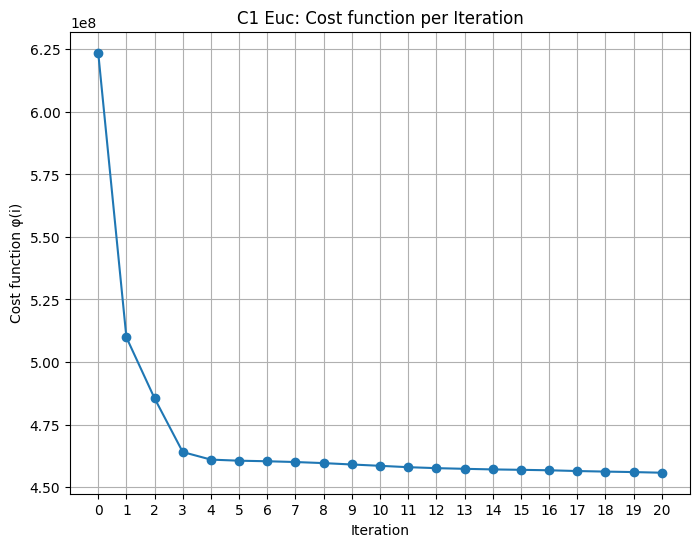

In [92]:
import matplotlib.pyplot as plt

iterations = list(range(0, len(costs)))
min_costs = [c for c in costs]
print(min_costs)

plt.figure(figsize=(8, 6))
plt.plot(iterations, min_costs, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Cost function φ(i)')
plt.title('C1 Euc: Cost function per Iteration')
plt.xticks(iterations)  # Set x-axis ticks to match iterations
plt.grid(True)
plt.show()

In [93]:
C1_Euc = (min_costs[0]-min_costs[10])/min_costs[0]

##### **C2 + Euclidean Distance**

In [94]:
# C2 + euclidean_distance
km = my_kmeans(data=documents_processed, centroids=c2_processed, k=2, max_iter=20, distance_measure=euclidean_distance)
centroids, assignments, costs = km.run_kmeans()

## If would like to see the output, uncomment this
# print("Centroids:")
# for i, centroid in enumerate(centroids):
#     print(f"Centroid {i}: {centroid}")

# print("\nAssigned Centroid Indices:")
# print(assignments)

# print("\nMinimum Distances:")
# print(costs)


[438747790.02791697, 249803933.62600315, 194494814.40631247, 169804841.451543, 156295748.80627602, 149094208.1089661, 142508531.61961526, 132303869.40652972, 117170969.83719075, 108547377.17857005, 102237203.317996, 98278015.74975672, 95630226.12177396, 93793314.05119297, 92377131.96821073, 91541606.25423887, 91045573.83042458, 90752240.101408, 90470170.18122733, 90216416.17563124, 90162390.9104141]


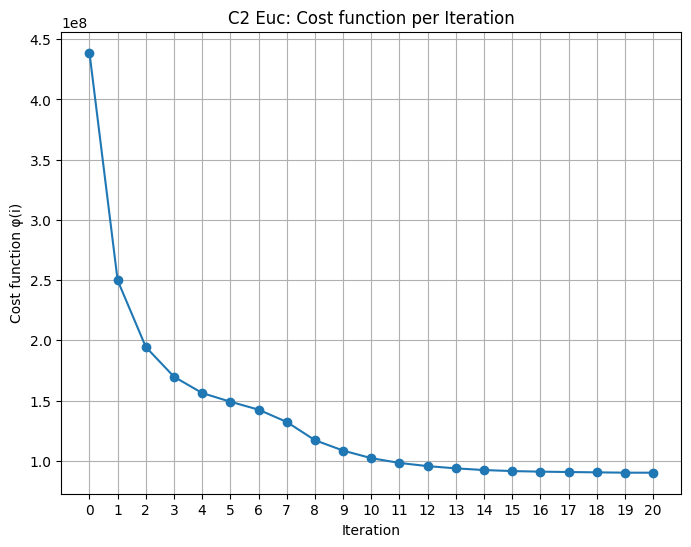

In [95]:
import matplotlib.pyplot as plt

iterations = list(range(0, len(costs)))
min_costs = [c for c in costs]
print(min_costs)


plt.figure(figsize=(8, 6))
plt.plot(iterations, min_costs, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Cost function φ(i)')
plt.title('C2 Euc: Cost function per Iteration')
plt.xticks(iterations)  # Set x-axis ticks to match iterations
plt.grid(True)
plt.show()

In [96]:
C2_Euc = (min_costs[0]-min_costs[10])/min_costs[0]

### b) Compute percentage change in cost after 10 iterations of the K-Means algorithm.

In [97]:
# percentage change in cost for c1.
print("C2 Euclidean Distance Percent Change:")
print(C1_Euc)

C2 Euclidean Distance Percent Change:
0.2648391714456054


In [98]:
# percentage change in cost for c2.
print("C2 Euclidean Distance Percent Change:")
print(C2_Euc)

C2 Euclidean Distance Percent Change:
0.7669795594605942


#### Is random initialization of k-means using q2-c1.txt better than initialization using q2-c2.txt in terms of cost φ(i)?

Random initialization of cluster2 (C2) is better than cluster1 (C1) with Euclidean distance. The percentage change in cost after 10 iterations for C2 is greater than that of C1. This shows faster convergence, therefore C2 is a better initialization.  


### c) Using Manhattan distance to compute phi(i) for every iteration i.

##### **C1 + Manhattan Distance**

In [99]:
# C1 + mannhattan_distance
km = my_kmeans(data=documents_processed, centroids=c1_processed, k=2, max_iter=20, distance_measure=manhattan_distance)
centroids, assignments, costs = km.run_kmeans()

## If would like to see the output, uncomment this
# print("Centroids:")
# for i, centroid in enumerate(centroids):
#     print(f"Centroid {i}: {centroid}")

# print("\nAssigned Centroid Indices:")
# print(assignments)

# print("\nMinimum Distances:")
# print(costs)


[911884445.17187, 742773376.7173811, 710503527.4448584, 691531518.7948387, 684128938.8591821, 679435592.5719607, 674734050.2089773, 661786907.696679, 638295920.1874764, 534855705.5059727, 349885602.48810863, 321195025.2419958, 318752467.15876853, 316466212.1067739, 313886322.265297, 312080524.93162745, 310813384.77848285, 308129200.0546763, 305391777.35118496, 303176946.37547004, 300824931.3102552]


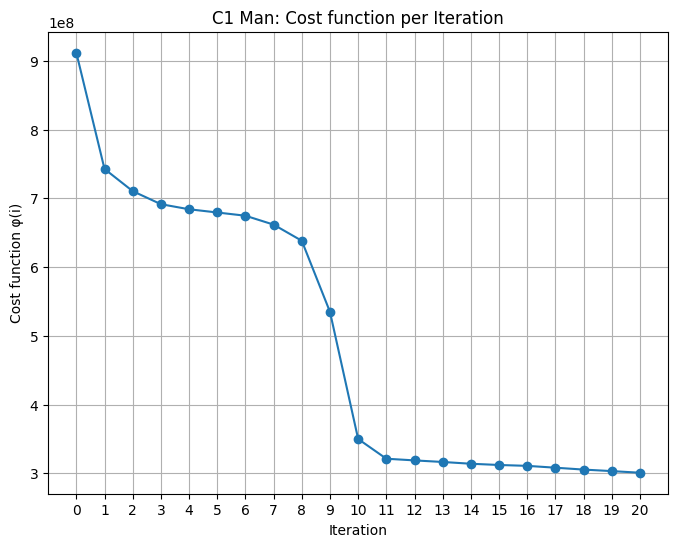

In [100]:
import matplotlib.pyplot as plt

iterations = list(range(0, len(costs)))
min_costs = [c for c in costs]
print(min_costs)

plt.figure(figsize=(8, 6))
plt.plot(iterations, min_costs, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Cost function φ(i)')
plt.title('C1 Man: Cost function per Iteration')
plt.xticks(iterations)  # Set x-axis ticks to match iterations
plt.grid(True)
plt.show()

In [101]:
C1_Man=(min_costs[0]-min_costs[10])/min_costs[0]

##### **C2 + Manhattan Distance**

In [102]:
# C2 + mannhattan_distance
km = my_kmeans(data=documents_processed, centroids=c2_processed, k=2, max_iter=20, distance_measure=manhattan_distance)
centroids, assignments, costs = km.run_kmeans()

## If would like to see the output, uncomment this
# print("Centroids:")
# for i, centroid in enumerate(centroids):
#     print(f"Centroid {i}: {centroid}")

# print("\nAssigned Centroid Indices:")
# print(assignments)

# print("\nMinimum Distances:")
# print(costs)


[655439563.75341, 425797401.16884565, 340841790.1586253, 300225433.73988974, 288288125.2596762, 280744103.44819266, 263746381.60364747, 245483161.49866766, 210918225.27613884, 194368603.12692136, 187496282.8773877, 185418200.75729644, 183521866.89708894, 182150585.44948784, 181485856.88127458, 180706294.44807568, 179645731.17449284, 178877228.1555272, 178431912.69330698, 178185258.5584314, 177385176.5272688]


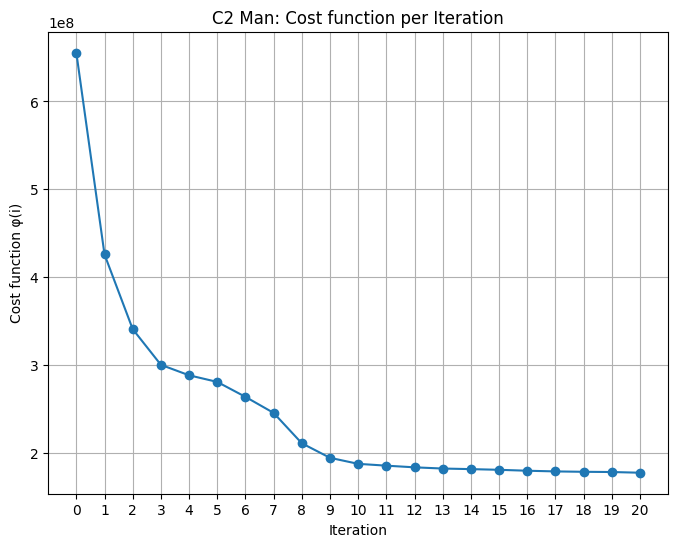

In [103]:
import matplotlib.pyplot as plt

iterations = list(range(0, len(costs)))
min_costs = [c for c in costs]
print(min_costs)

plt.figure(figsize=(8, 6))
plt.plot(iterations, min_costs, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Cost function φ(i)')
plt.title('C2 Man: Cost function per Iteration')
plt.xticks(iterations)  # Set x-axis ticks to match iterations
plt.grid(True)
plt.show()

In [104]:
C2_Man = (min_costs[0]-min_costs[10])/min_costs[0]

### d) Compute percentage change in cost after 10 iterations of the K-Means algorithm.

In [105]:
# percentage change in cost for c1.

print("C1 Manhattan Distance Percent Change:")
print(C1_Man)

C1 Manhattan Distance Percent Change:
0.6163048900103094


In [106]:
# percentage change in cost for c2.

print("C2 Manhattan Distance Percent Change:")
print(C2_Man)

C2 Manhattan Distance Percent Change:
0.7139381062020728


In [107]:
sc.stop()

#### Is random initialization of k-means using q2-c1.txt better than initialization using q2-c2.txt in terms of cost φ(i)?

Also for the manhattan distance, random initialization of cluster2 (C2) is better than cluster1 (C1) in terms of cost phi. The convergence happens faster with C2 intialization shown by the greater percentage change with C2 (0.7139) compared to that of C1 (0.6163). This is also evident on the graph that the saturation happens quicker with cluster2, starting at iteration 9. It happens later at iteration 11 with cluster 1 intialization.
